# Ghidra_bench study

In [313]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import json
import os
import numpy as np

## Dependencies and dataset

In [314]:
# Style
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

LOGS_PATH = './llm_server/logs/llm_metrics.csv'
REPORTS_PATH = './ghidra_bench/outputs/reports/*.json'

In [315]:
def load_metrics(path):
    try:
        df = pd.read_csv(path)     
        df = df.drop(columns=df.columns[:2])
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return pd.DataFrame()

    return df

df_metrics = load_metrics(LOGS_PATH)

print(f"Loaded {len(df_metrics)} hardware metric records.")
df_metrics.head()

Loaded 2451 hardware metric records.


,model_id,operation,duration_sec,peak_vram_gb,system_ram_gb,prompt_tokens,generated_tokens
0,qwen-coder,score,5.0741,7.4493,1.6602,3607,0
1,qwen-coder,score,0.4703,6.4897,1.6612,2049,0
2,qwen-coder,score,0.3725,6.2819,1.6612,1714,0
3,qwen-coder,score,0.2734,5.9342,1.6612,1157,0
4,qwen-coder,score,3.6950,7.4493,1.6624,3607,0


# LLM

## Time LLM study

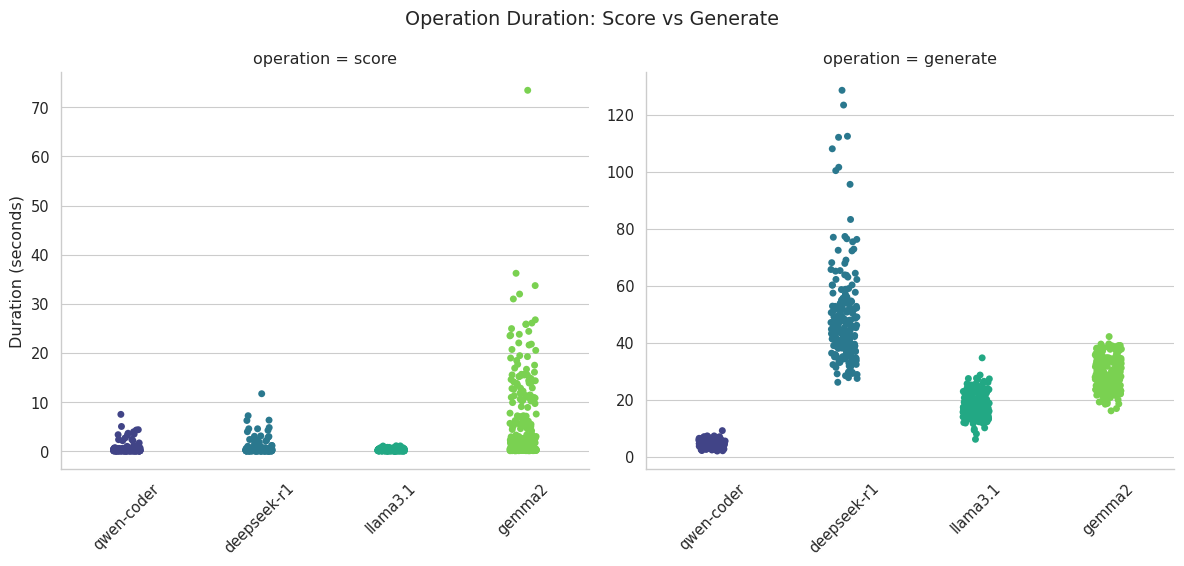

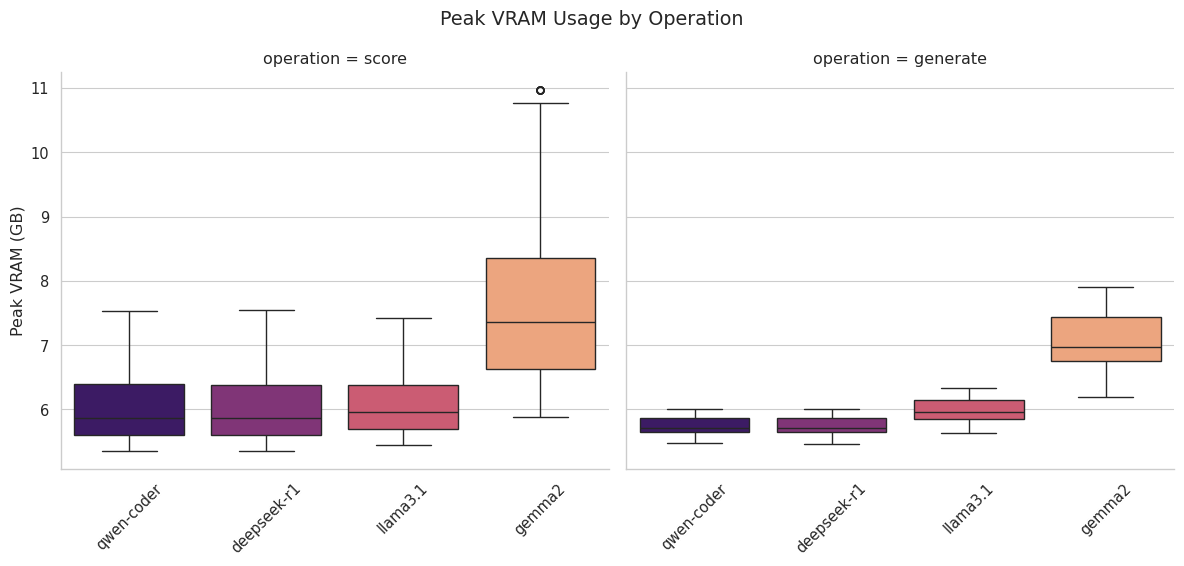

In [316]:
if not df_metrics.empty:
    g = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='duration_sec', 
        col='operation',  # split for 'score' and 'generate'
        kind='strip', #'box',
        hue='model_id', 
        palette='viridis', 
        height=5, 
        aspect=1.2,
        sharey=False      # Independent Y-axis
    )
    g.figure.suptitle('Operation Duration: Score vs Generate', y=1.05)
    g.set_axis_labels("", "Duration (seconds)")
    g.set_xticklabels(rotation=45)
    
    g_vram = sns.catplot(
        data=df_metrics, 
        x='model_id', 
        y='peak_vram_gb',
        col='operation',
        kind='box', 
        hue='model_id', 
        palette='magma', 
        height=5, 
        aspect=1.2
    )
    g_vram.figure.suptitle('Peak VRAM Usage by Operation', y=1.05)
    g_vram.set_axis_labels("", "Peak VRAM (GB)")
    g_vram.set_xticklabels(rotation=45)
    # for ax in g_vram.axes.flat:
    #     ax.axhline(16, color='red', linestyle='--', linewidth=2, label='Limit VRAM')
        

    plt.show()
else:
    print("No metrics data found.")

## Generation study

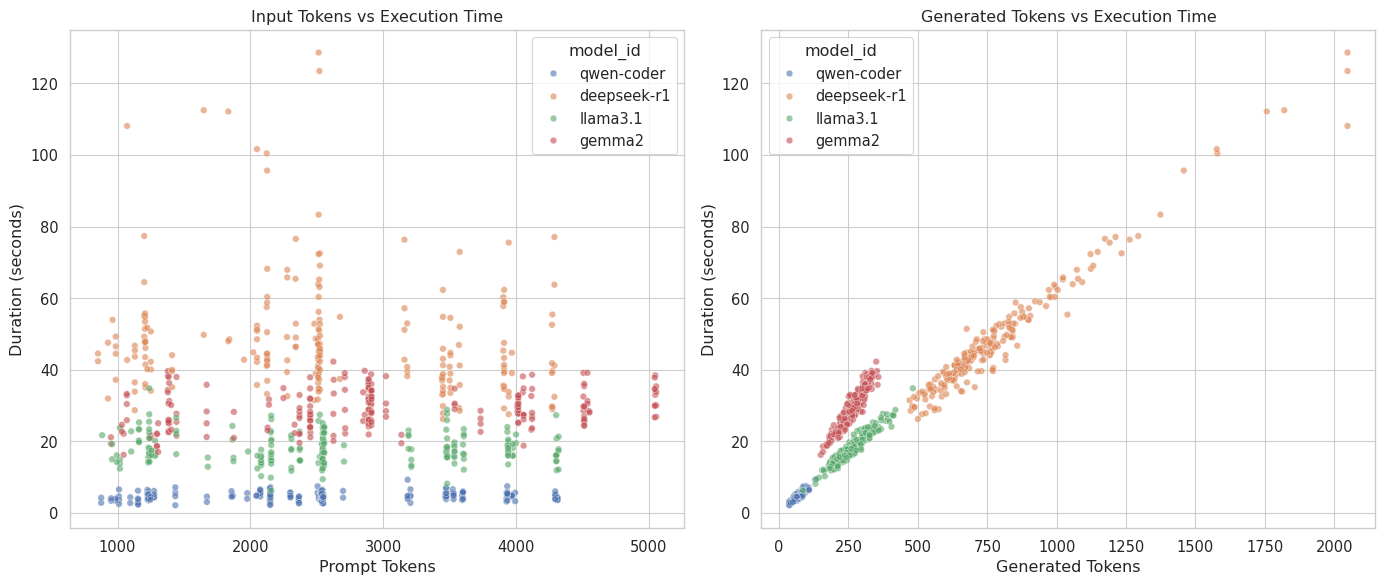

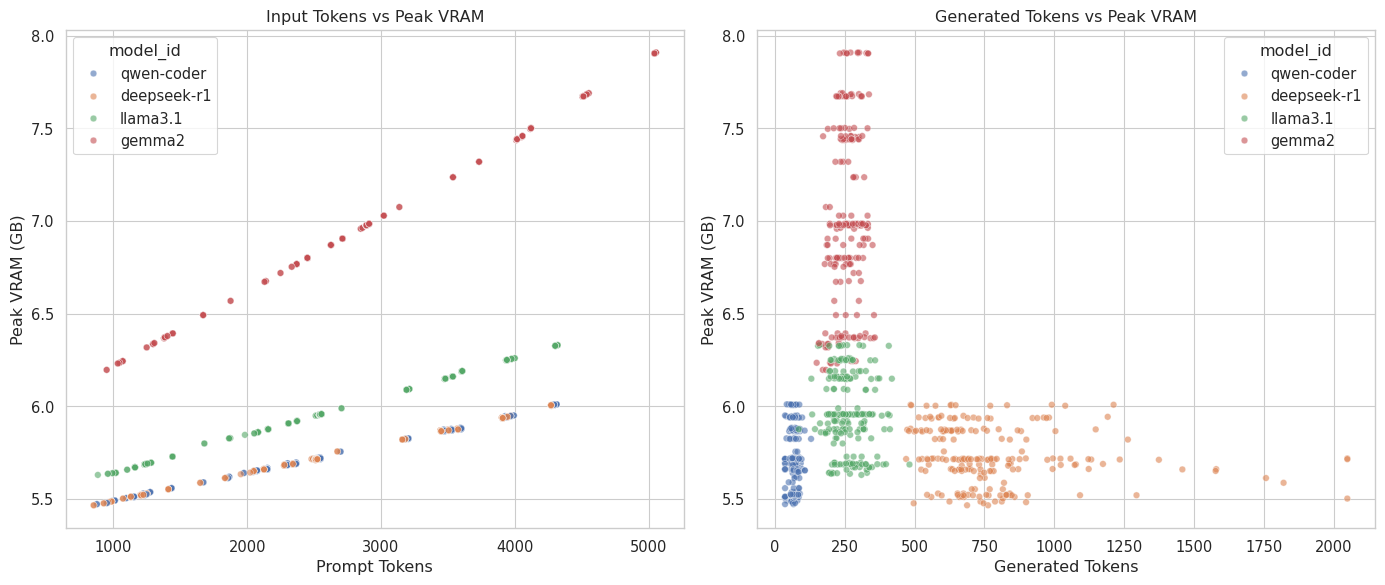

In [317]:
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='generated_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Generated Tokens vs Execution Time')
plt.xlabel('Generated Tokens')
plt.ylabel('Duration (seconds)')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='generated_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Generated Tokens vs Peak VRAM')
plt.xlabel('Generated Tokens')
plt.ylabel('Peak VRAM (GB)')

plt.tight_layout()
plt.show()



## Score study

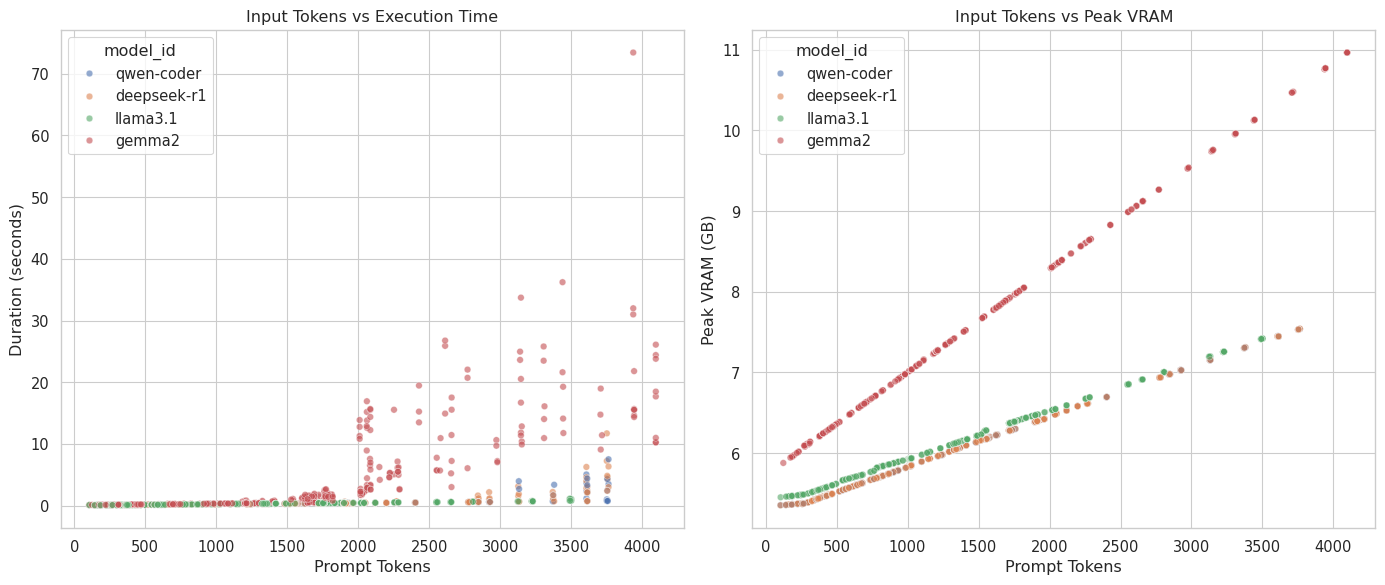

In [318]:
df_gen = df_metrics[df_metrics['operation'] == 'score'].copy()

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='duration_sec', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Execution Time')
plt.xlabel('Prompt Tokens')
plt.ylabel('Duration (seconds)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=df_gen, x='prompt_tokens', y='peak_vram_gb', hue='model_id', alpha=0.6)
plt.title('Input Tokens vs Peak VRAM')
plt.xlabel('Prompt Tokens')
plt.ylabel('Peak VRAM (GB)')


plt.tight_layout()
plt.show()

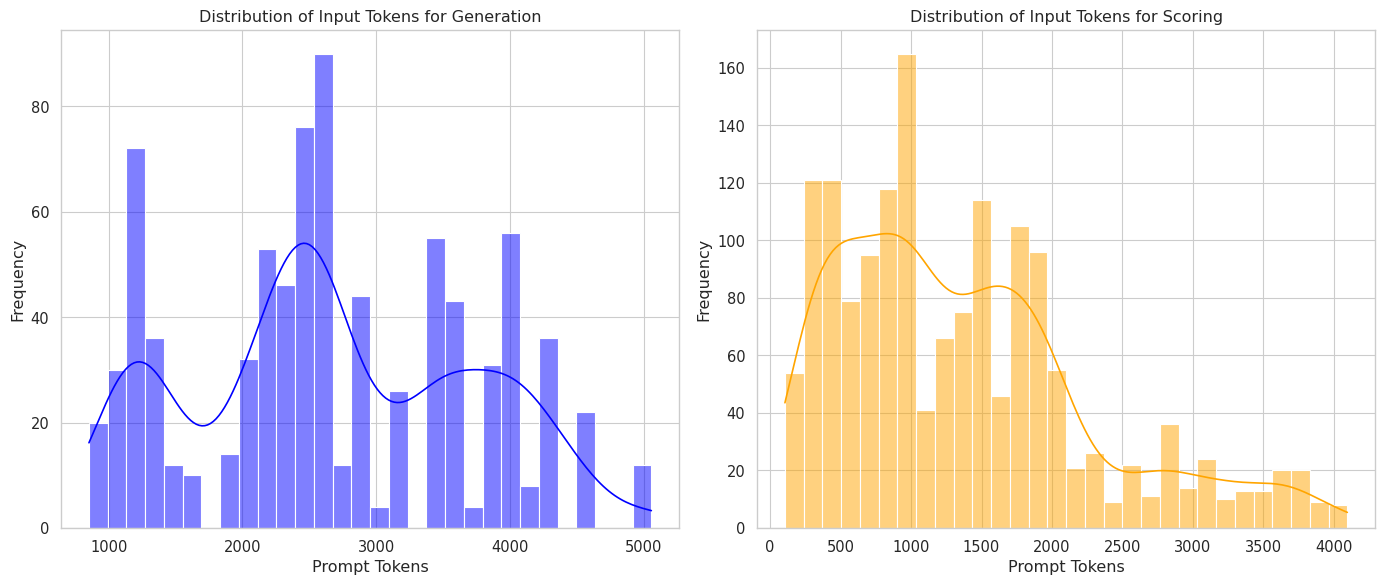

In [319]:
#distribution token input generation vs score
df_gen = df_metrics[df_metrics['operation'] == 'generate'].copy()
df_score = df_metrics[df_metrics['operation'] == 'score'].copy()
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(data=df_gen, x='prompt_tokens', bins=30, kde=True, color='blue')
plt.title('Distribution of Input Tokens for Generation')
plt.xlabel('Prompt Tokens')
plt.ylabel('Frequency') 

plt.subplot(1, 2, 2)
sns.histplot(data=df_score, x='prompt_tokens', bins=30, kde=True, color='orange')
plt.title('Distribution of Input Tokens for Scoring')
plt.xlabel('Prompt Tokens')
plt.ylabel('Frequency') 
plt.tight_layout()
plt.show()

# Reports study

### Generation humanity

In [320]:
import re

def load_reports_new_format(path_pattern):
    all_records = []
    files = glob.glob(path_pattern)
    
    print(f"Found {len(files)} report files.")
    
    for f_path in files:
        try:
            with open(f_path, 'r') as f:
                data = json.load(f)
            
            pr_number = data.get('pr', 'unknown')
            
            results_dict = data.get('results', {})
            
            for model_id, items in results_dict.items():
                for item in items:
                    metrics = item.get('metrics', {})

                    def get_metric(metrics, key):
                        value = metrics.get(key, -1)
                        return value if value != -1 else np.nan
                    
                    ppl_keys = ['base_ppl', 'pr_ppl', 'source_ppl', 'delta_ppl', 'base_ast_ppl', 'pr_ast_ppl', 'source_ast_ppl']
                    for key in ppl_keys:
                        metrics[key] = get_metric(metrics, key)

                    llm_qualitative = item.get('llm_qualitative', {})

                    if 'error' in llm_qualitative:
                        continue

                    qual_winner = llm_qualitative.get('winner')
                    if qual_winner == 'Error':
                            continue
            
                    llm_qualitative_source = item.get('llm_qualitative_source', {})
                    if 'error' in llm_qualitative_source:
                        continue
                    qual_s_winner = llm_qualitative_source.get('winner', 'tie')
                    if qual_s_winner == 'Error':
                            continue
                        
                    llm_ast_qualitative = item.get('llm_ast', {})
                    if 'error' in llm_ast_qualitative:
                        continue
                    qual_ast_winner = llm_ast_qualitative.get('winner', 'tie')
                    if qual_ast_winner == 'Error':
                            continue
                    
                    llm_ast_s_qualitative = item.get('llm_ast_source', {})
                    if 'error' in llm_ast_s_qualitative:
                        continue
                    qual_ast_s_winner = llm_ast_s_qualitative.get('winner', 'tie')
                    if qual_ast_s_winner == 'Error':
                            continue

                    source_len = len(item.get('source_code', ''))
                    base_len = len(item.get('function_base', ''))
                    pr_len = len(item.get('function_pr', ''))

                    source_ast = item.get('source_ast', '')
                    base_ast = item.get('base_ast', '')
                    pr_ast = item.get('pr_ast', '')
                    
                    record = {
                        'pr': pr_number,
                        'model': model_id,
                        'binary': item.get('binary'),
                        'function': item.get('function'),
                        'source_ast': source_ast,
                        'base_ast': base_ast,
                        'pr_ast': pr_ast,
                        'source_code': item.get('source_code', ''),
                        'function_base': item.get('function_base', ''),
                        'function_pr': item.get('function_pr', ''),
                        # Quantitative Metrics
                        'base_ppl': metrics.get('base_ppl', np.nan),
                        'pr_ppl': metrics.get('pr_ppl', np.nan),
                        'delta_ppl': metrics.get('delta_ppl', np.nan),
                        'source_ppl': metrics.get('source_ppl', np.nan),
                        'ast_base_ppl': metrics.get('base_ast_ppl', np.nan),
                        'ast_pr_ppl': metrics.get('pr_ast_ppl', np.nan),
                        'ast_source_ppl': metrics.get('source_ast_ppl', np.nan),
                        'ast_delta_ppl': metrics.get('pr_ast_ppl', np.nan) - metrics.get('base_ast_ppl', np.nan) if not np.isnan(metrics.get('base_ast_ppl', np.nan)) and not np.isnan(metrics.get('pr_ast_ppl', np.nan)) else np.nan,
                        
                        # Qualitative Metrics
                        'qualitative_winner': qual_ast_winner,
                        'qualitative_winner_s': qual_s_winner,
                        'qualitative_ast_winner': qual_ast_winner,
                        'qualitative_ast_winner_s': qual_ast_s_winner,
                        'source_len': source_len,
                        'len_change': pr_len - base_len,
                        'ast_source_len': len(source_ast),
                        'ast_base_len': len(base_ast),
                        'ast_pr_len': len(pr_ast),
                        'ast_len_change': len(pr_ast) - len(base_ast),
                        'is_improvement': metrics.get('delta_ppl', np.nan) < 0
                    }
                    all_records.append(record)
                    
        except Exception as e:
            print(f"Error loading {f_path}: {e}")

    df = pd.DataFrame(all_records)
    return df

df_reports = load_reports_new_format(REPORTS_PATH)
print(f"Loaded {len(df_reports)} valid records after filtering errors.")
df_reports.head()

Found 1 report files.
Loaded 25 valid records after filtering errors.


,pr,model,binary,function,source_ast,base_ast,pr_ast,source_code,function_base,function_pr,...,qualitative_winner_s,qualitative_ast_winner,qualitative_ast_winner_s,source_len,len_change,ast_source_len,ast_base_len,ast_pr_len,ast_len_change,is_improvement
0,8587,qwen-coder,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,"type id(type *id, type id, type *id, type id, ...","type id(type *id, type id, id, type *id, type...","type id(type *id, type id, id, type *id, type...",readstat_error_t dta_parse_timestamp(const cha...,\nundefined8\ndta_parse_timestamp(char *param_...,\nundefined8\ndta_parse_timestamp(char *param_...,...,TIE,TIE,BASE,6760,6,4391,3695,3690,-5,True
1,8587,qwen-coder,task-readstat_sav_parse_date-O2.so,sav_parse_date,"type id(type *id, type id, type *id, type id, ...","type id(type *id, type id, id, type *id, type...","type id(type *id, type id, id, type *id, type...",readstat_error_t sav_parse_date(const char *da...,"\nundefined8 sav_parse_date(char *param_1,ulon...","\nundefined8 sav_parse_date(char *param_1,ulon...",...,TIE,TIE,TIE,6405,1,4327,3718,3713,-5,True
2,8587,qwen-coder,task-readstat_sav_parse_date-O3.so,sav_parse_date,"type id(type *id, type id, type *id, type id, ...","type id(type *id, type id, id, type *id, type...","type id(type *id, type id, id, type *id, type...",readstat_error_t sav_parse_date(const char *da...,"\nundefined8 sav_parse_date(char *param_1,ulon...","\nundefined8 sav_parse_date(char *param_1,ulon...",...,TIE,TIE,TIE,6405,1,4327,3718,3713,-5,True
3,8587,qwen-coder,task-readstat_sav_parse_time-O2.so,sav_parse_time,"type id(type *id, type id, type *id, type id, ...","type id(type *id, type id, type *id, type *id,...","type id(type *id, type id, type *id, type *id,...",readstat_error_t sav_parse_time(const char *da...,"\nundefined8 sav_parse_time(char *param_1,ulon...","\nundefined8 sav_parse_time(char *param_1,ulon...",...,TIE,TIE,TIE,4262,1,2822,2886,2881,-5,True
4,8587,qwen-coder,task-file_file_replace-O0.so,file_replace,"type id(type *id, type *id, type *id){\n type...","type id( id, type id, type id){\n type id;\n ...","type id( id, type id, type id){\n type id;\n ...",file_protected int\nfile_replace(struct magic_...,"\nint file_replace(long param_1,undefined8 par...","\nint file_replace(long param_1,undefined8 par...",...,TIE,PR,PR,487,-21,399,646,646,0,True


## Perplexity

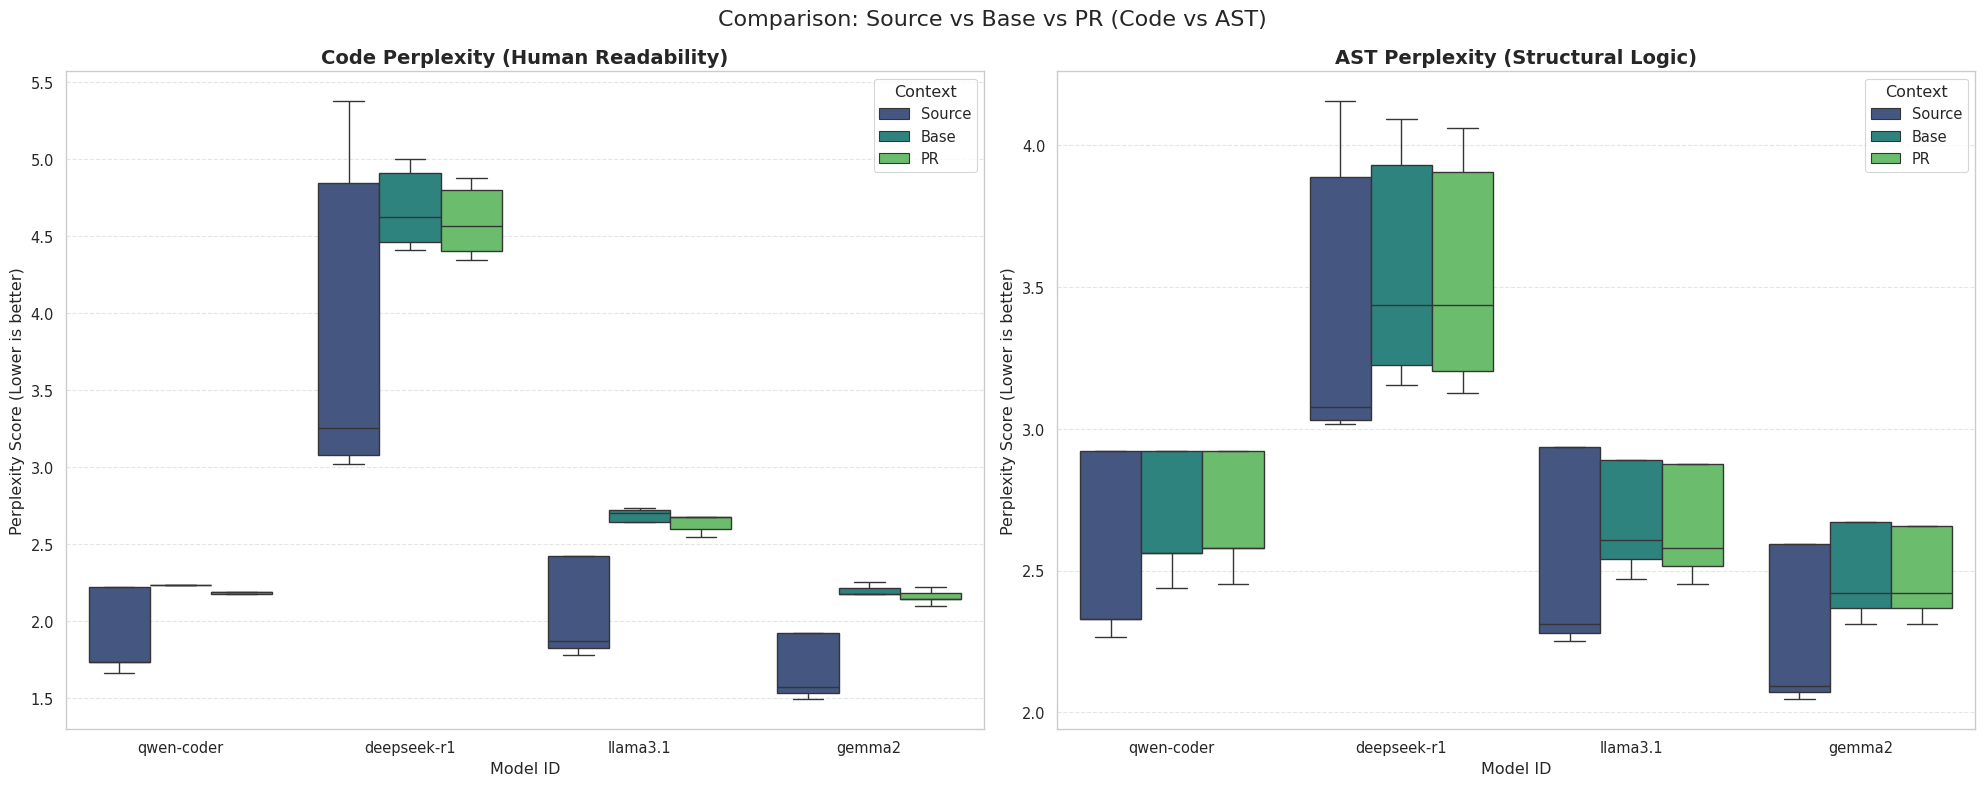

In [321]:
if not df_reports.empty:
    df_code = df_reports.melt(
        id_vars=['model'], 
        value_vars=['source_ppl', 'base_ppl', 'pr_ppl'],
        var_name='metric_type', 
        value_name='perplexity'
    )

    df_code['metric_type'] = df_code['metric_type'].replace({
        'source_ppl': 'Source', 'base_ppl': 'Base', 'pr_ppl': 'PR'
    })

    df_ast = df_reports.melt(
        id_vars=['model'], 
        value_vars=['ast_source_ppl', 'ast_base_ppl', 'ast_pr_ppl'],
        var_name='metric_type', 
        value_name='perplexity'
    )
    df_ast['metric_type'] = df_ast['metric_type'].replace({
        'ast_source_ppl': 'Source', 'ast_base_ppl': 'Base', 'ast_pr_ppl': 'PR'
    })

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=False)
    
    sns.boxplot(
        data=df_code, 
        x='model', 
        y='perplexity', 
        hue='metric_type', 
        showfliers=False,
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title('Code Perplexity (Human Readability)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Perplexity Score (Lower is better)')
    axes[0].set_xlabel('Model ID')
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)
    axes[0].legend(title='Context')

    sns.boxplot(
        data=df_ast, 
        x='model', 
        y='perplexity', 
        hue='metric_type',
        showfliers=False,
        palette='viridis',
        ax=axes[1]
    )
    axes[1].set_title('AST Perplexity (Structural Logic)', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Perplexity Score (Lower is better)')
    axes[1].set_xlabel('Model ID')
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)
    axes[1].legend(title='Context')

    plt.suptitle('Comparison: Source vs Base vs PR (Code vs AST)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("DataFrame vuoto, impossibile generare i grafici.")

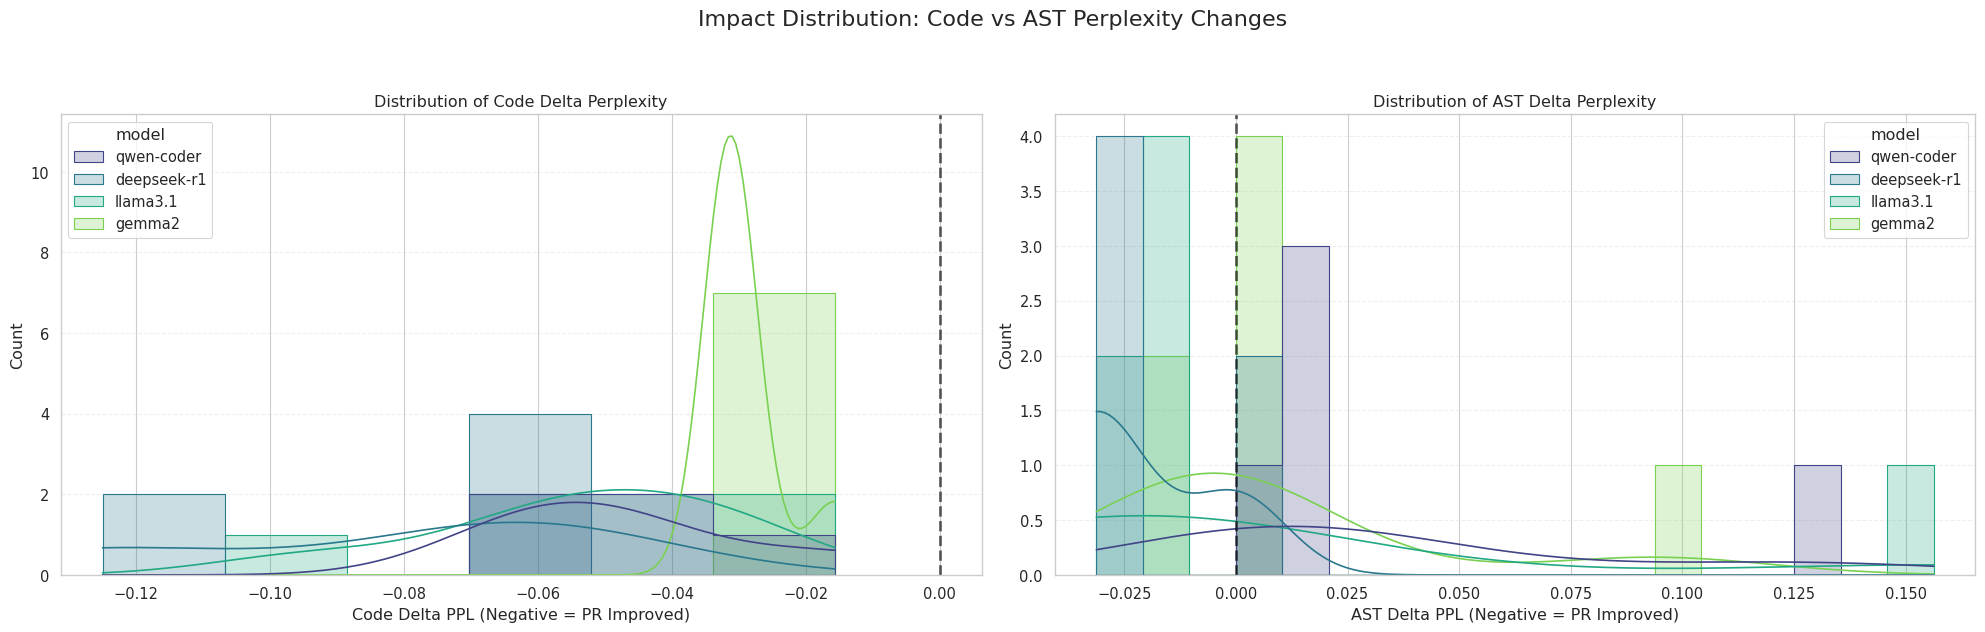

In [322]:
if not df_reports.empty:

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    sns.histplot(
        data=df_reports, 
        x='delta_ppl', 
        hue='model', 
        kde=True, 
        element="step", 
        palette='viridis',
        ax=axes[0]
    )
    axes[0].set_title('Distribution of Code Delta Perplexity')
    axes[0].set_xlabel('Code Delta PPL (Negative = PR Improved)')
    axes[0].axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.6, label='No Change')
    axes[0].grid(axis='y', linestyle='--', alpha=0.3)
    
    df_ast_valid = df_reports.dropna(subset=['ast_delta_ppl'])
    
    has_variance = not df_ast_valid.empty and not (df_ast_valid['ast_delta_ppl'] == 0).all()
    
    if has_variance:
        group_vars = df_ast_valid.groupby('model')['ast_delta_ppl'].var()
        is_singular = (group_vars.fillna(0) == 0).any()
        
        sns.histplot(
            data=df_ast_valid, 
            x='ast_delta_ppl', 
            hue='model', 
            kde=not is_singular,
            element="step", 
            palette='viridis',
            ax=axes[1]
        )
        axes[1].set_title('Distribution of AST Delta Perplexity')
        axes[1].set_xlabel('AST Delta PPL (Negative = PR Improved)')
        axes[1].axvline(0, color='black', linestyle='--', linewidth=2, alpha=0.6, label='No Change')
        axes[1].grid(axis='y', linestyle='--', alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, "No Variance / No Data for AST Delta", 
                     ha='center', va='center', transform=axes[1].transAxes, fontsize=12)
        axes[1].set_title('Distribution of AST Delta Perplexity (Singular)')

    plt.suptitle('Impact Distribution: Code vs AST Perplexity Changes', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

### Perplexity trough PRs

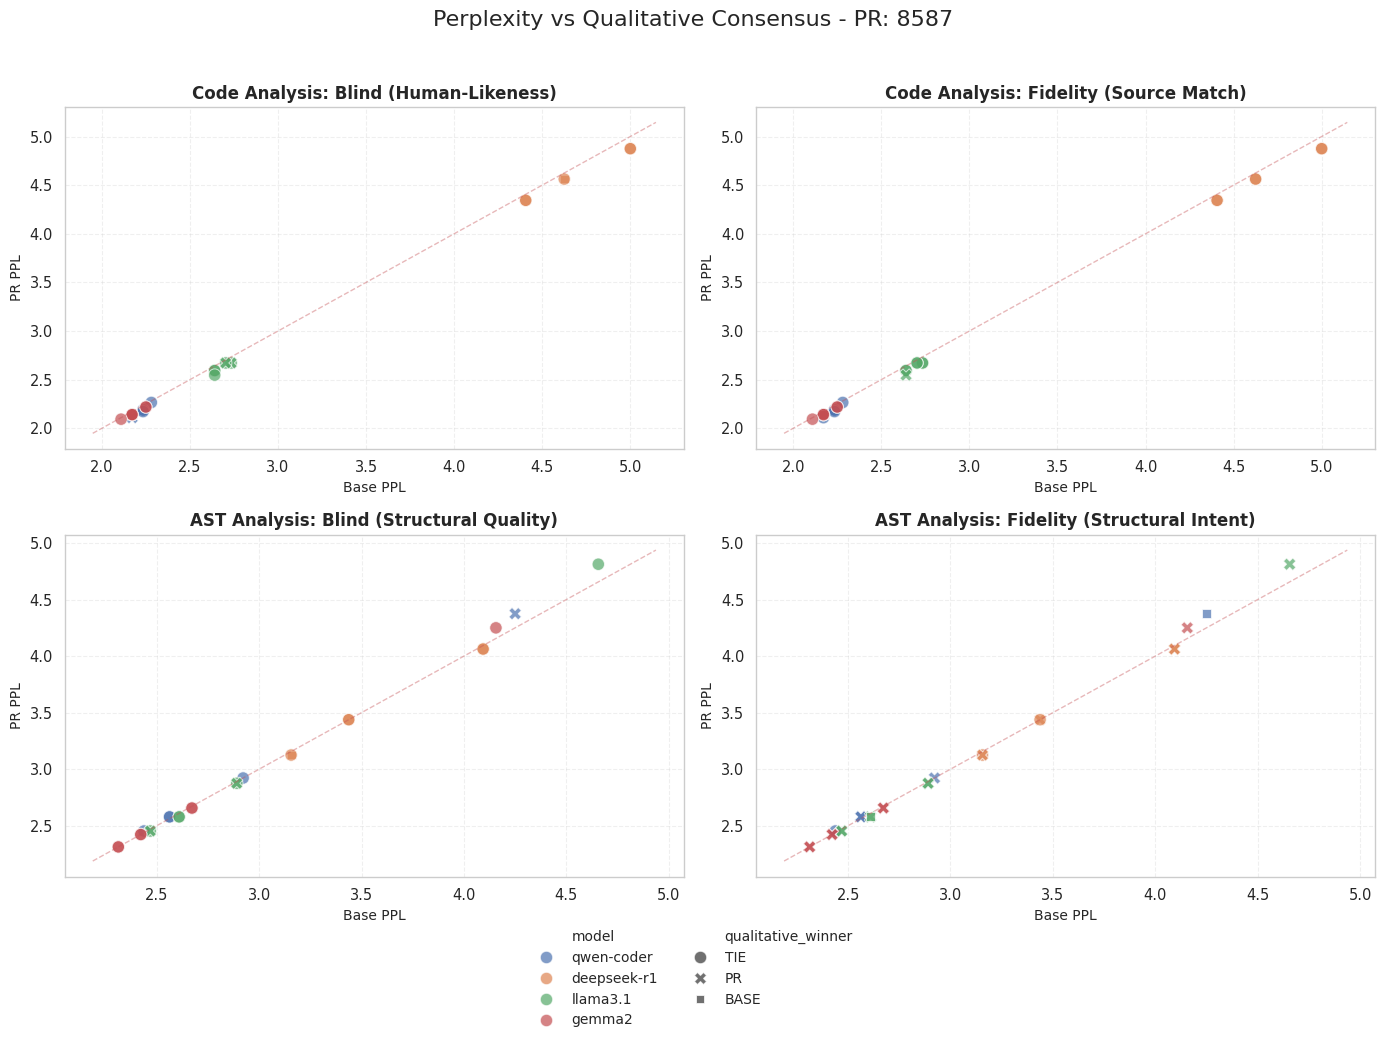

In [323]:
unique_prs = df_reports['pr'].unique()

plot_configs = [
    {
        'title': 'Code Analysis: Blind (Human-Likeness)',
        'x': 'base_ppl', 
        'y': 'pr_ppl',
        'style': 'qualitative_winner'
    },
    {
        'title': 'Code Analysis: Fidelity (Source Match)',
        'x': 'base_ppl', 
        'y': 'pr_ppl',
        'style': 'qualitative_winner_s'
    },
    {
        'title': 'AST Analysis: Blind (Structural Quality)',
        'x': 'ast_base_ppl',
        'y': 'ast_pr_ppl', 
        'style': 'qualitative_ast_winner'
    },
    {
        'title': 'AST Analysis: Fidelity (Structural Intent)',
        'x': 'ast_base_ppl', 
        'y': 'ast_pr_ppl',
        'style': 'qualitative_ast_winner_s'
    }
]

for pr_id in unique_prs:
    df_pr = df_reports[df_reports['pr'] == pr_id]
    
    if df_pr.empty:
        continue

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    fig.suptitle(f'Perplexity vs Qualitative Consensus - PR: {pr_id}', fontsize=16, y=0.98)
    
    handles, labels = [], []

    for i, config in enumerate(plot_configs):
        ax = axes[i]
        x_col = config['x']
        y_col = config['y']
        style_col = config['style']
        
        if x_col not in df_pr.columns or y_col not in df_pr.columns or style_col not in df_pr.columns:
            ax.text(0.5, 0.5, "Missing Data", ha='center', va='center')
            continue
            
        df_plot = df_pr.dropna(subset=[x_col, y_col, style_col])
        
        if df_plot.empty:
            ax.text(0.5, 0.5, "No Valid Data", ha='center', va='center')
            continue

        # Diagonal line for reference
        curr_min = min(df_plot[x_col].min(), df_plot[y_col].min())
        curr_max = max(df_plot[x_col].max(), df_plot[y_col].max())
        margin = (curr_max - curr_min) * 0.05 if curr_max != curr_min else 0.1
        
        ax.plot([curr_min-margin, curr_max+margin], [curr_min-margin, curr_max+margin], 
                'r--', alpha=0.4, linewidth=1) # Removed label from here to avoid duplicate in legend

        sns.scatterplot(
            data=df_plot, 
            x=x_col, 
            y=y_col, 
            hue='model', 
            style=style_col, 
            s=80,            
            alpha=0.7,
            ax=ax,
            legend=(i==0)
        )
        
        ax.set_title(config['title'], fontsize=12, fontweight='bold')
        ax.set_xlabel(f'Base PPL', fontsize=10)
        ax.set_ylabel(f'PR PPL', fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.3)

        if i == 0:
            h, l = ax.get_legend_handles_labels()
            handles.extend(h)
            labels.extend(l)
            ax.get_legend().remove()

    # legend position
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), 
               ncol=2, frameon=False, fontsize=10)
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.96])
    plt.show()

### Check length Bias

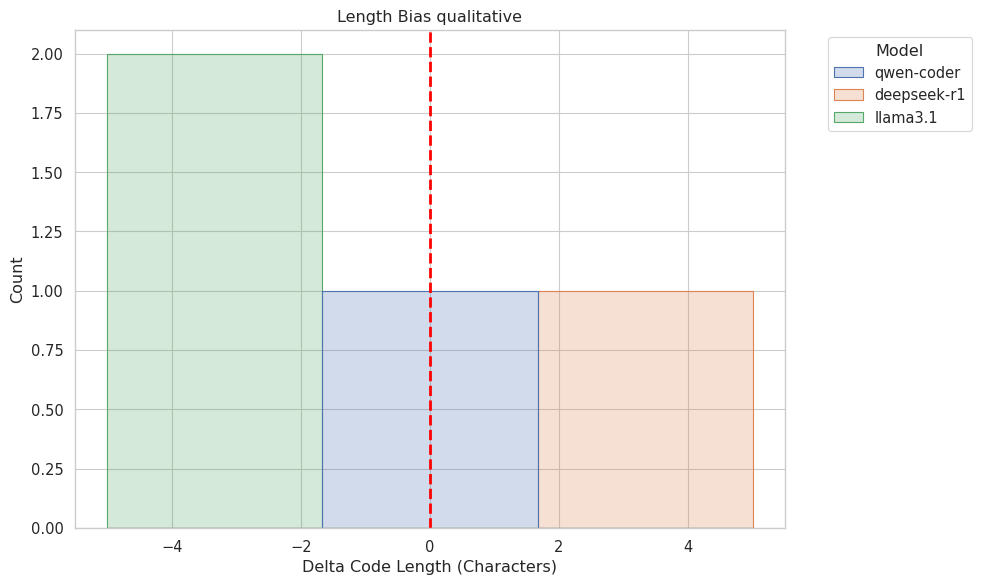

Average Length Bias: -1.25 chars (Positive = prefers longer, Negative = prefers shorter)


In [324]:
df_bias = df_reports.copy()

valid_pr_labels = ['pr',]
valid_base_labels = ['base']

df_bias['qualitative_winner'] = df_bias['qualitative_winner'].astype(str).str.lower().str.strip()

mask_valid = df_bias['qualitative_winner'].isin(valid_pr_labels + valid_base_labels)
df_bias = df_bias[mask_valid].copy()


def get_winner_len_delta(row):
    w = row['qualitative_winner']
    if w in valid_pr_labels:
        return row['ast_len_change']
    elif w in valid_base_labels:
        return -row['ast_len_change']
    return None

df_bias['ast_delta_len_winner'] = df_bias.apply(get_winner_len_delta, axis=1)

df_bias = df_bias.dropna(subset=['ast_delta_len_winner'])

plt.figure(figsize=(10, 6))

ax = sns.histplot(
    data=df_bias, 
    x='ast_delta_len_winner', 
    hue='model', 
    element="step", 
    #kde=True,
    #palette='viridis'
)

plt.axvline(0, color='red', linestyle='--', linewidth=2, label='No Length Diff')

plt.title('Length Bias qualitative')
plt.xlabel('Delta Code Length (Characters)')
plt.ylabel('Count')
try:
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.05, 1), title='Model')
except AttributeError:
    # Fallback 
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Model')
plt.tight_layout()
plt.show()

mean_bias = df_bias['ast_delta_len_winner'].mean()
print(f"Average Length Bias: {mean_bias:.2f} chars (Positive = prefers longer, Negative = prefers shorter)")

## Check position Bias

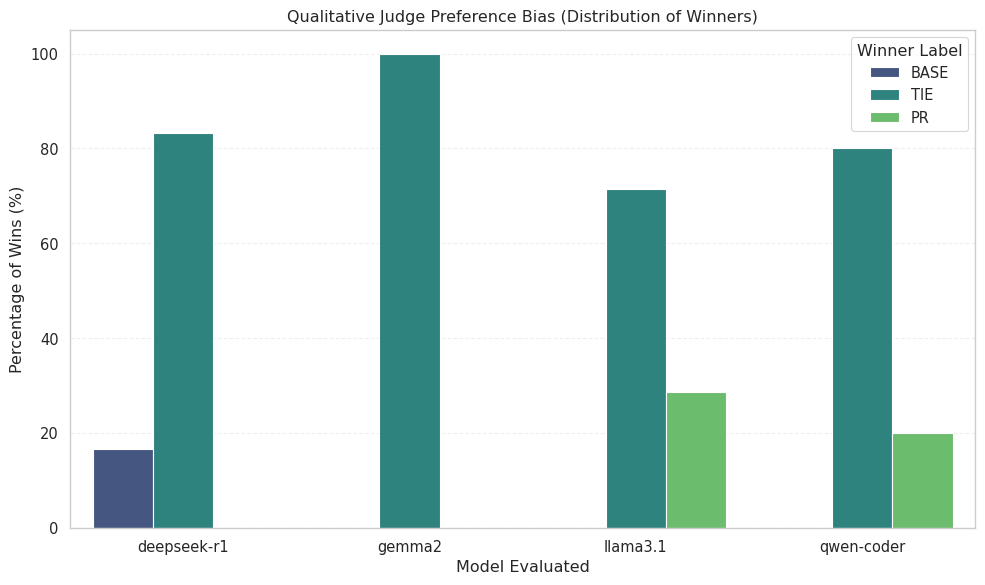

In [325]:
plt.figure(figsize=(10, 6))
    
bias_counts = df_reports.groupby(['model', 'qualitative_ast_winner']).size().reset_index(name='count')
total_counts = df_reports.groupby('model').size().reset_index(name='total')
bias_data = bias_counts.merge(total_counts, on='model')
bias_data['percentage'] = bias_data['count'] / bias_data['total'] * 100

sns.barplot(
    data=bias_data,
    x='model',
    y='percentage',
    hue='qualitative_ast_winner',
    palette='viridis'
)

plt.title('Qualitative Judge Preference Bias (Distribution of Winners)')
plt.ylabel('Percentage of Wins (%)')
plt.xlabel('Model Evaluated')
plt.legend(title='Winner Label')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


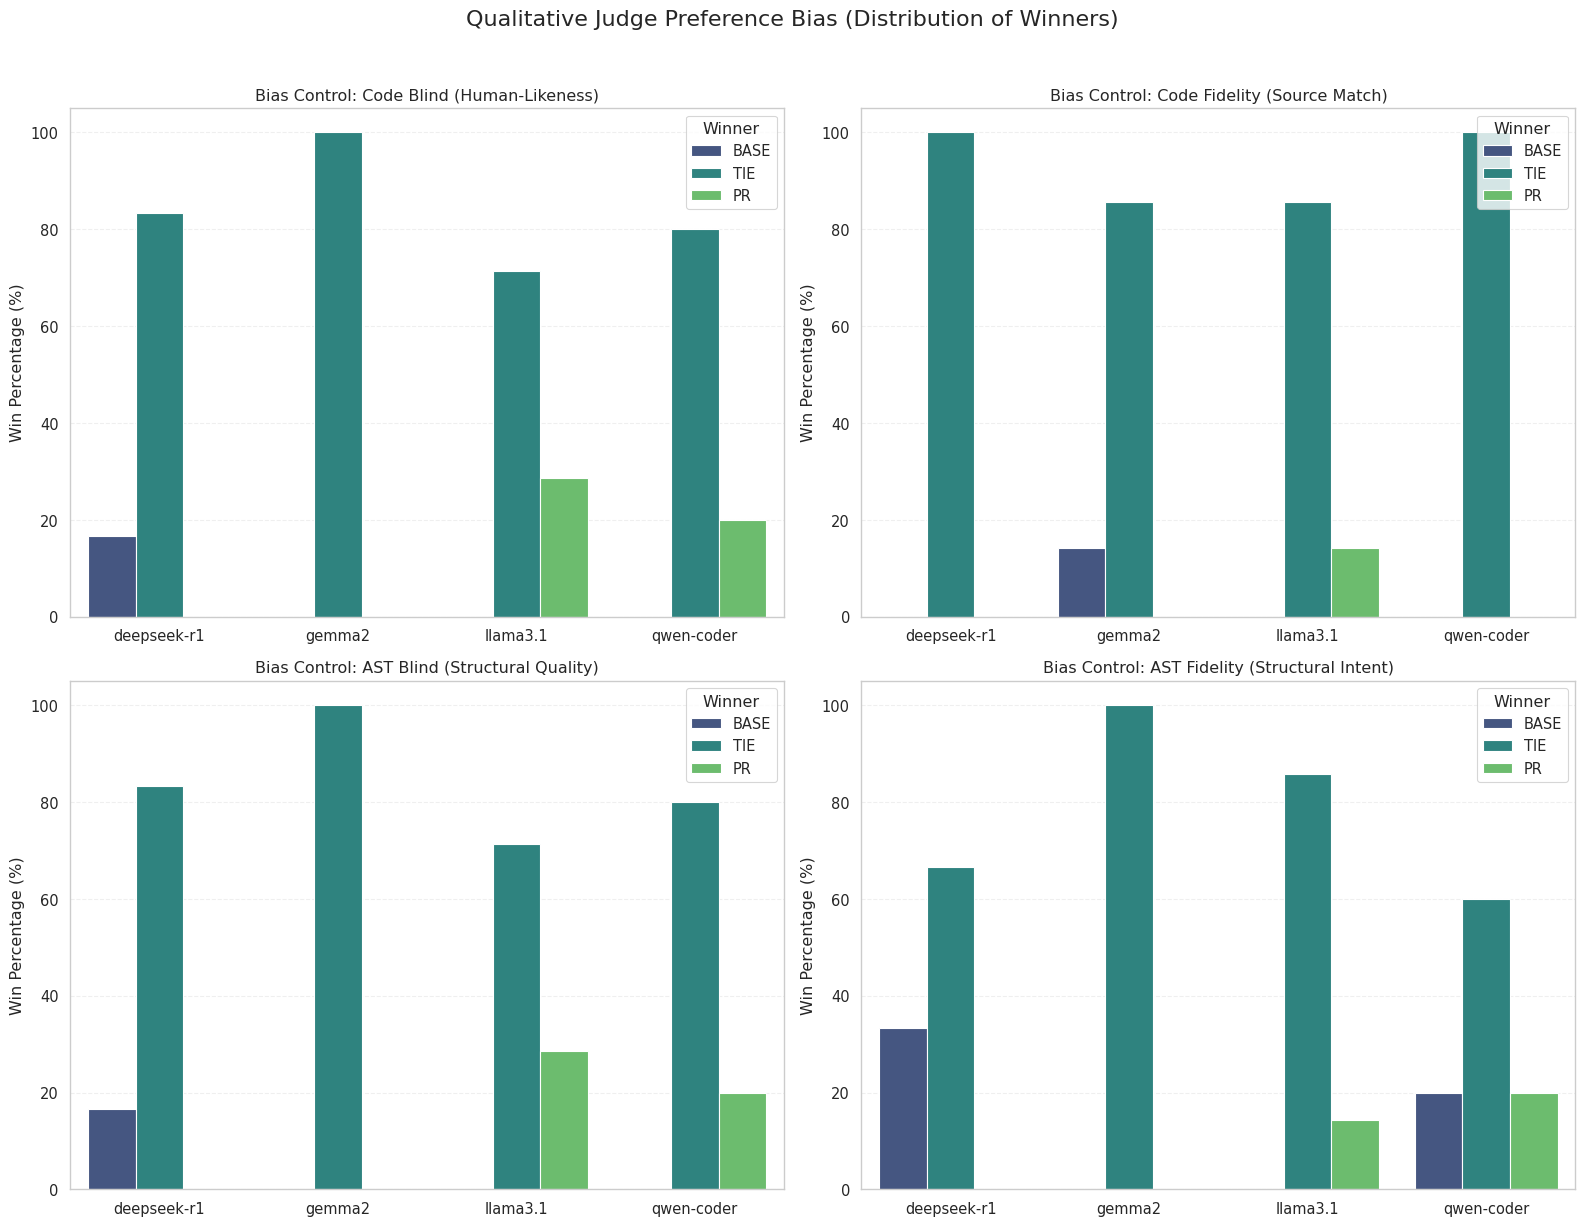

In [326]:
def plot_bias_control_grid(df):
    analysis_types = [
        ('qualitative_winner', 'Code Blind (Human-Likeness)'),
        ('qualitative_winner_s', 'Code Fidelity (Source Match)'),
        ('qualitative_ast_winner', 'AST Blind (Structural Quality)'),
        ('qualitative_ast_winner_s', 'AST Fidelity (Structural Intent)')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, (col, title) in enumerate(analysis_types):
        # Filtra dati validi per questa colonna
        df_valid = df.dropna(subset=[col]).copy()
        
        if df_valid.empty:
            axes[i].text(0.5, 0.5, "No Data", ha='center', va='center')
            axes[i].set_title(title)
            continue
            
        # Calcolo percentuali
        counts = df_valid.groupby(['model', col]).size().reset_index(name='count')
        totals = df_valid.groupby('model').size().reset_index(name='total')
        data = counts.merge(totals, on='model')
        data['percentage'] = data['count'] / data['total'] * 100

        ORDER = ['BASE', 'TIE', 'PR']
        
        sns.barplot(
            data=data,
            x='model',
            y='percentage',
            hue=col,
            palette='viridis',
            hue_order=ORDER,
            ax=axes[i]
        )
        
        axes[i].set_title(f'Bias Control: {title}')
        axes[i].set_ylabel('Win Percentage (%)')
        axes[i].set_xlabel('')
        axes[i].legend(title='Winner', loc='upper right')
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)

    plt.suptitle("Qualitative Judge Preference Bias (Distribution of Winners)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Esecuzione
plot_bias_control_grid(df_reports)

## Coherence ad alignment

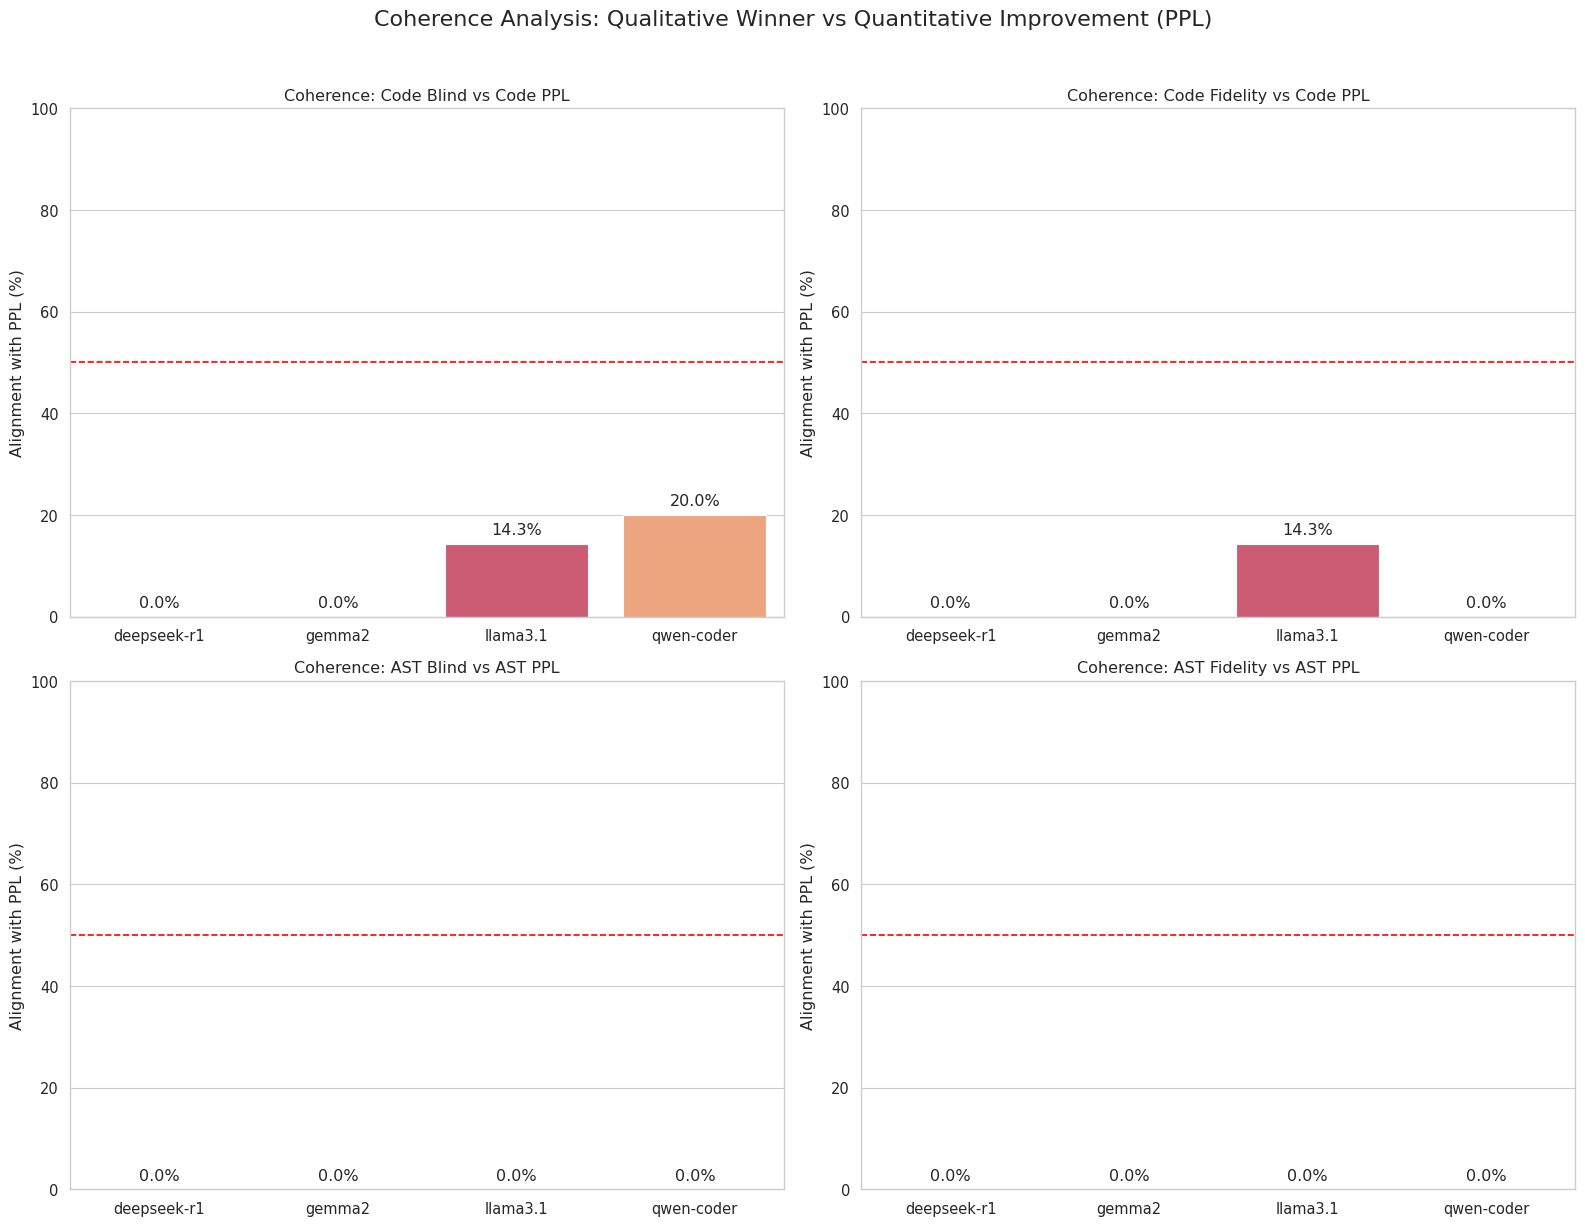

In [331]:
def plot_coherence_control_grid(df):
    analysis_pairs = [
        ('qualitative_winner', 'delta_ppl', 'Code Blind vs Code PPL'),
        ('qualitative_winner_s', 'delta_ppl', 'Code Fidelity vs Code PPL'),
        ('qualitative_ast_winner', 'ast_delta_ppl', 'AST Blind vs AST PPL'),
        ('qualitative_ast_winner_s', 'ast_delta_ppl', 'AST Fidelity vs AST PPL')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    THRESHOLD = 0.05
    
    for i, (qual_col, quant_col, title) in enumerate(analysis_pairs):
        df_valid = df.dropna(subset=[qual_col, quant_col]).copy()
        
        if df_valid.empty:
            axes[i].text(0.5, 0.5, "No Data", ha='center', va='center')
            axes[i].set_title(title)
            continue

        # PR win (Qual) ,delta < 0 (Quant) -> Aligned
        # BASE win (Qual) , delta > 0 (Quant) -> Aligned
        # TIE (Qual) -> Neutral ignored for this plot, here we count it as Non-Aligned if PPL changes significantly
        
        def check_alignment(row):
            w_qual = str(row[qual_col]).upper()
            d_quant = row[quant_col]
            
            if w_qual == 'PR' and d_quant < -THRESHOLD: return True
            if w_qual == 'BASE' and d_quant > THRESHOLD: return True
            #if w_qual == 'TIE' and abs(d_quant) <= THRESHOLD: return True
            return False

        df_valid['is_aligned'] = df_valid.apply(check_alignment, axis=1)
        
        alignment_stats = df_valid.groupby('model')['is_aligned'].mean().reset_index()
        alignment_stats['percentage'] = alignment_stats['is_aligned'] * 100
        
        sns.barplot(
            data=alignment_stats,
            x='model',
            y='percentage',
            hue='model',
            palette='magma',
            ax=axes[i],
            dodge=False
        )
        
        axes[i].set_title(f'Coherence: {title}')
        axes[i].set_ylabel('Alignment with PPL (%)')
        axes[i].set_xlabel('')
        axes[i].set_ylim(0, 100)
        axes[i].axhline(50, color='red', linestyle='--', label='Random (50%)')
        axes[i].legend().remove()
        
        for p in axes[i].patches:
            axes[i].annotate(f'{p.get_height():.1f}%', 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.suptitle("Coherence Analysis: Qualitative Winner vs Quantitative Improvement (PPL)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Esecuzione
plot_coherence_control_grid(df_reports)

In [328]:
if not df_reports.empty:
    print(f"=== Top 20 Functions with Highest Perplexity Change for Model: ===")
    unique_models = df_reports['model'].unique()
    df_consistency = df_reports[
        ~df_reports['qualitative_winner'].astype(str).str.lower().isin(['tie', 'none', 'unknown'])
    ]
    for model in unique_models:
        print(f"\n--- Model: {model} ---")
        df_model = df_consistency[df_consistency['model'] == model]
        df_model = df_model.assign(abs_delta=df_model['ast_delta_ppl'].abs())
        
        top_changes = df_model.sort_values('abs_delta', ascending=False).head(20)
        
        cols = ['pr', 'binary', 'function', 'abs_delta', 'ast_delta_ppl', 'qualitative_winner', 'qualitative_ast_winner', 'qualitative_winner_s', 'qualitative_ast_winner_s']
        
        # Styling the table for readability
        styled_table = top_changes[cols].style.background_gradient(
            subset=['abs_delta'], cmap='RdBu_r'
        ).format({'abs_delta': "{:.4f}"})
        
        display(styled_table)

=== Top 20 Functions with Highest Perplexity Change for Model: ===

--- Model: qwen-coder ---


,pr,binary,function,abs_delta,ast_delta_ppl,qualitative_winner,qualitative_ast_winner,qualitative_winner_s,qualitative_ast_winner_s
4,8587,task-file_file_replace-O0.so,file_replace,0.1250,0.125000,PR,PR,TIE,PR



--- Model: deepseek-r1 ---


,pr,binary,function,abs_delta,ast_delta_ppl,qualitative_winner,qualitative_ast_winner,qualitative_winner_s,qualitative_ast_winner_s
5,8587,task-readstat_dta_parse_timestamp-O2.so,dta_parse_timestamp,0.0312,-0.031250,BASE,BASE,TIE,BASE



--- Model: llama3.1 ---


,pr,binary,function,abs_delta,ast_delta_ppl,qualitative_winner,qualitative_ast_winner,qualitative_winner_s,qualitative_ast_winner_s
12,8587,task-readstat_dta_parse_timestamp-O3.so,dta_parse_timestamp,0.0156,-0.015625,PR,PR,TIE,TIE
16,8587,task-readstat_sav_parse_time-O3.so,sav_parse_time,0.0156,-0.015625,PR,PR,TIE,TIE



--- Model: gemma2 ---


,pr,binary,function,abs_delta,ast_delta_ppl,qualitative_winner,qualitative_ast_winner,qualitative_winner_s,qualitative_ast_winner_s


In [332]:
#print ast when winner is base or pr
for index, row in df_ast_valid.iterrows():
    if row['qualitative_ast_winner'].lower() in ['base', 'pr']:
        print(f"Model: {row['model']}, Function: {row['function']}, AST Winner: {row['qualitative_ast_winner']}, pr: {row['pr']}")
        print("----SOURCE AST-----")
        print(row.get('source_ast', 'N/A'))
        print("----- SOURCE CODE -----")
        print(row.get('source_code', 'N/A'))
        print("----- BASE AST -----")
        print(row.get('base_ast', 'N/A'))
        print("----- PR AST -----")
        print(row.get('pr_ast', 'N/A'))
        print("--------------------\n")

Model: qwen-coder, Function: file_replace, AST Winner: PR, pr: 8587
----SOURCE AST-----
type id(type *id, type *id, type *id){
  type id;
  type id, , id = num;
  id = call(id, &id, id, id);
  if(id == num){
    type id;
    type id = num;
    while(call(id, &id, id->id.id, num, &id, num) == num){
      id->id.id[id.id] = str;
      if(call(id, str, id, (id.id != num ? id->id.id op id.id : str)) == num)goto lbl;
      id upd;
    }
    id = id;
  }
  lbl:
  call(&id);
  return id;
}
----- SOURCE CODE -----
file_protected int
file_replace(struct magic_set *ms, const char *pat, const char *rep)
{
	file_regex_t rx;
	int rc, rv = -1;

	rc = file_regcomp(ms, &rx, pat, REG_EXTENDED);
	if (rc == 0) {
		regmatch_t rm;
		int nm = 0;
		while (file_regexec(ms, &rx, ms->o.buf, 1, &rm, 0) == 0) {
			ms->o.buf[rm.rm_so] = '\0';
			if (file_printf(ms, "%s%s", rep,
			    rm.rm_eo != 0 ? ms->o.buf + rm.rm_eo : "") == -1)
				goto out;
			nm++;
		}
		rv = nm;
	}
out:
	file_regfree(&rx);
	return rv;
}



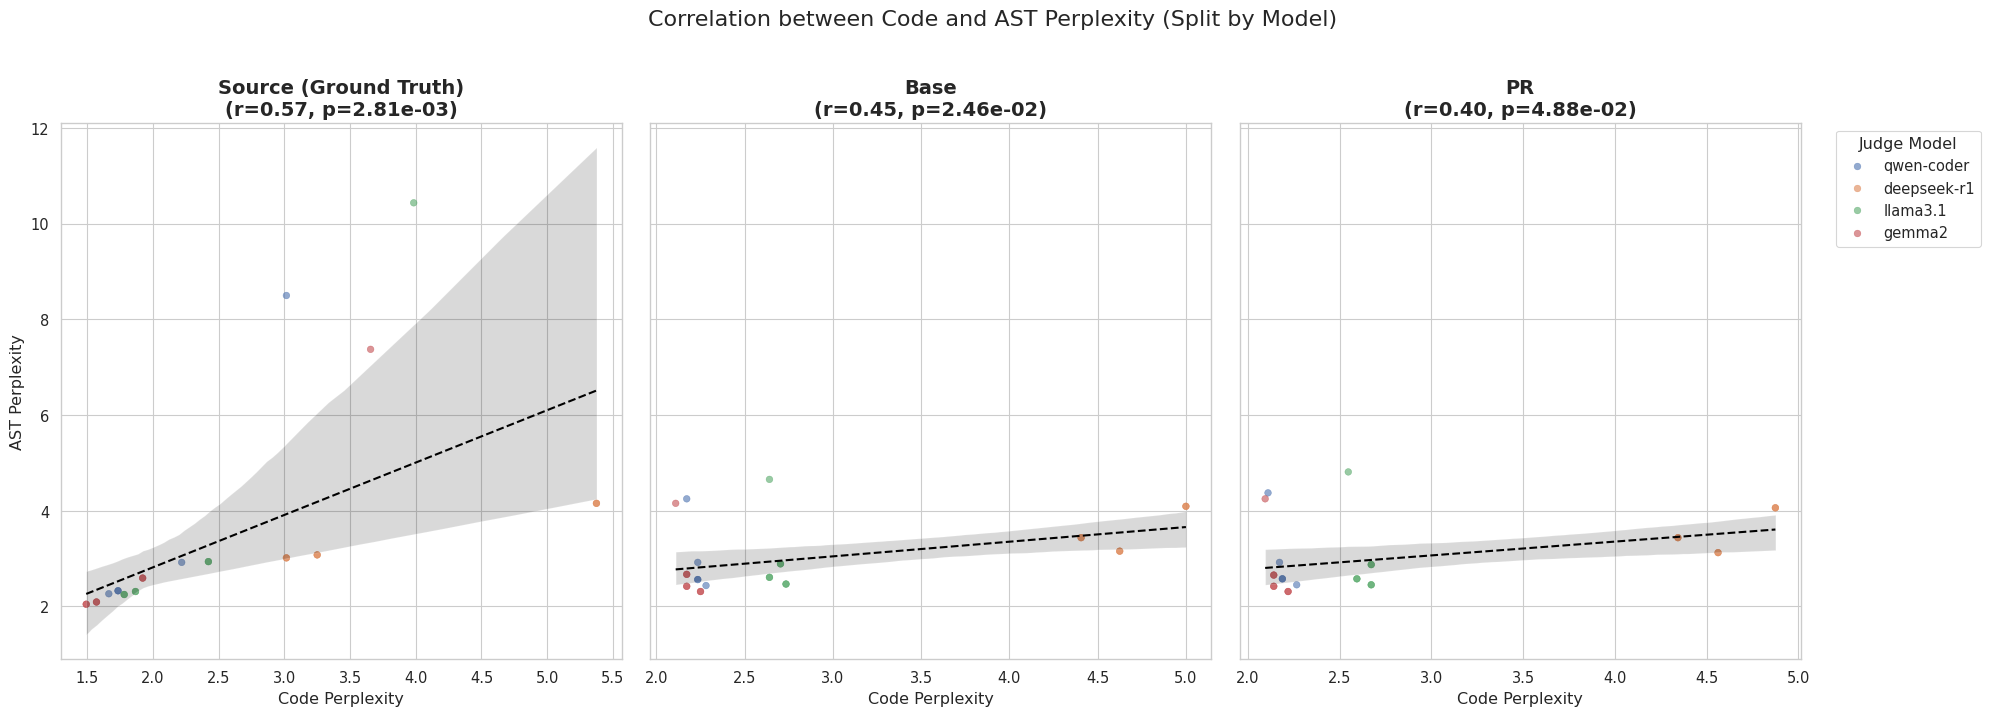

In [330]:
from scipy.stats import pearsonr

def plot_ppl_correlation_by_model(df):
    fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)
    
    categories = [
        ('source_ppl', 'ast_source_ppl', 'Source (Ground Truth)'),
        ('base_ppl', 'ast_base_ppl', 'Base'),
        ('pr_ppl', 'ast_pr_ppl', 'PR')
    ]
    
    for i, (code_col, ast_col, label) in enumerate(categories):
        valid_data = df[[code_col, ast_col, 'model']].dropna()
        
        if len(valid_data) > 1:
            corr, p_value = pearsonr(valid_data[code_col], valid_data[ast_col])
            
            sns.scatterplot(
                data=valid_data, 
                x=code_col, 
                y=ast_col, 
                hue='model', 
                ax=axes[i],
                alpha=0.6,
                edgecolor=None
            )
            
            sns.regplot(
                data=valid_data, 
                x=code_col, 
                y=ast_col, 
                ax=axes[i],
                scatter=False, 
                color='black', 
                line_kws={'linestyle': '--', 'linewidth': 1.5, 'label': f'Global r={corr:.2f}'}
            )
            
            axes[i].set_title(f'{label}\n(r={corr:.2f}, p={p_value:.2e})', fontsize=14, fontweight='bold')
            axes[i].set_xlabel('Code Perplexity')
            axes[i].set_ylabel('AST Perplexity' if i == 0 else "")
            
            if i < 2:
                axes[i].get_legend().remove()
            else:
                axes[i].legend(title='Judge Model', bbox_to_anchor=(1.05, 1), loc='upper left')
        else:
            axes[i].set_title(f'{label}: No Valid Data', fontsize=14, fontweight='bold')

    plt.suptitle('Correlation between Code and AST Perplexity (Split by Model)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

plot_ppl_correlation_by_model(df_reports)